# Data challenge summary

### Katrina Kutchko, Insight Data Science, 7/7/17

This project builds a model to identify malignant breast cells, based on their features. It uses a random forest to predict malignancy, with an accuracy of 0.971 and an area under the receiver operator characteristic of 0.9948 on a test data set.

## Data exploration

In [1]:
library(tidyverse)
library(GGally)
library(randomForest)
library(pROC)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var



In [2]:
cancer.data <- read.csv('breast-cancer-wisconsin.data', header=FALSE,
                        na.string = '?',
                       col.names=c('id', 'thickness', 'size_uniform',
                                  'shape_uniform', 'adhesion',
                                  'epithelial_cell_size', 'bare_nuclei',
                                  'bland_chromatin', 'normal_nucleoli',
                                  'mitoses', 'class')) %>%
    mutate(class = as.factor(ifelse(class==2, 'benign', 'malignant')))
head(cancer.data)

id,thickness,size_uniform,shape_uniform,adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
1000025,5,1,1,1,2,1,3,1,1,benign
1002945,5,4,4,5,7,10,3,2,1,benign
1015425,3,1,1,1,2,2,3,1,1,benign
1016277,6,8,8,1,3,4,3,7,1,benign
1017023,4,1,1,3,2,1,3,1,1,benign
1017122,8,10,10,8,7,10,9,7,1,malignant


In [3]:
str(cancer.data)

'data.frame':	699 obs. of  11 variables:
 $ id                  : int  1000025 1002945 1015425 1016277 1017023 1017122 1018099 1018561 1033078 1033078 ...
 $ thickness           : int  5 5 3 6 4 8 1 2 2 4 ...
 $ size_uniform        : int  1 4 1 8 1 10 1 1 1 2 ...
 $ shape_uniform       : int  1 4 1 8 1 10 1 2 1 1 ...
 $ adhesion            : int  1 5 1 1 3 8 1 1 1 1 ...
 $ epithelial_cell_size: int  2 7 2 3 2 7 2 2 2 2 ...
 $ bare_nuclei         : int  1 10 2 4 1 10 10 1 1 1 ...
 $ bland_chromatin     : int  3 3 3 3 3 9 3 3 1 2 ...
 $ normal_nucleoli     : int  1 2 1 7 1 7 1 1 1 1 ...
 $ mitoses             : int  1 1 1 1 1 1 1 1 5 1 ...
 $ class               : Factor w/ 2 levels "benign","malignant": 1 1 1 1 1 2 1 1 1 1 ...


In [4]:
# examine samples with incomplete data
# small number (n=16) of samples with missing data
# no apparent pattern
cancer.data %>%
filter(is.na(bare_nuclei))

id,thickness,size_uniform,shape_uniform,adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
1057013,8,4,5,1,2,NA,7,3,1,malignant
1096800,6,6,6,9,6,NA,7,8,1,benign
1183246,1,1,1,1,1,NA,2,1,1,benign
1184840,1,1,3,1,2,NA,2,1,1,benign
1193683,1,1,2,1,3,NA,1,1,1,benign
1197510,5,1,1,1,2,NA,3,1,1,benign
1241232,3,1,4,1,2,NA,3,1,1,benign
169356,3,1,1,1,2,NA,3,1,1,benign
432809,3,1,3,1,2,NA,2,1,1,benign
563649,8,8,8,1,2,NA,6,10,1,malignant


Warning message:
“Removed 16 rows containing non-finite values (stat_count).”

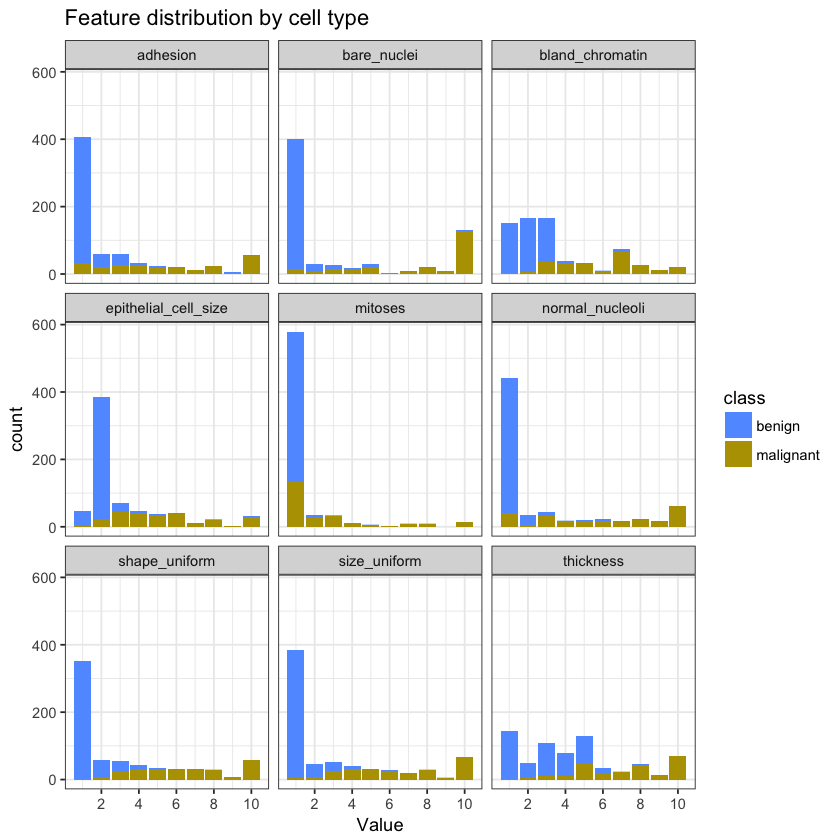

In [5]:
# bar plot of counts for each feature
cancer.data %>% gather(Feature, Value, -c(id, class)) %>%
ggplot(aes(x=Value)) +
geom_bar(aes(fill=class)) +
facet_wrap(~ Feature) +
scale_fill_discrete(h.start=240) +
theme_bw() +
scale_x_continuous(breaks=seq(0, 10, 2)) +
ggtitle('Feature distribution by cell type')

From this plot, it's apparent that all variables in the data set are associated with malignancy to some extent.

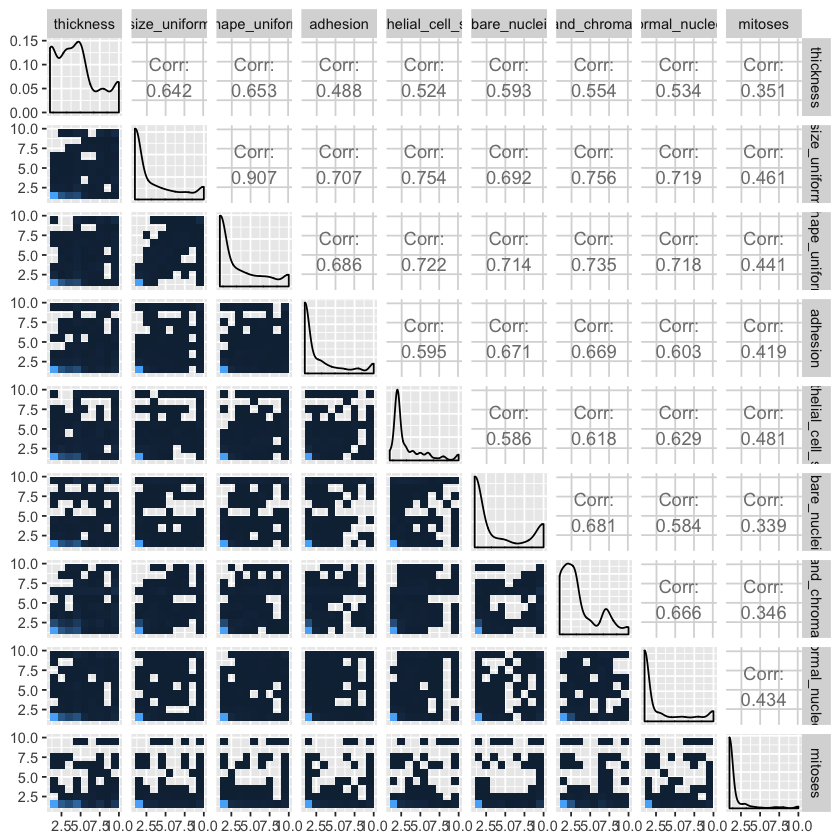

In [6]:
# remove missing data
cancer.data.cleaned <- cancer.data %>%
filter(! is.na(bare_nuclei))

# plot feature correlations
my_bin <- function(data, mapping, ..., low = "#132B43", high = "#56B1F7") {
  ggplot(data = data, mapping = mapping) +
    geom_bin2d(...) +
    scale_fill_gradient(low = low, high = high)
}
ggpairs(select(cancer.data.cleaned, -c(id, class)),
       lower=list(continuous = wrap(my_bin, binwidth = 1)))

Features are definitely correlated, with size uniformity and shape uniformity having the highest intercorrelation. There's also a bias towards cells having the lowest value (1) for each feature.

## Model building

I'm using a random forest classification model because it handles ordinal data well and avoids overfitting, which may be a risk with so many features.

The data set already contains relevant features for malignancy, so feature engineering is not necessary to build a model.

In [7]:
# divide data into test and training set
set.seed(100)

samp <- sample(nrow(cancer.data.cleaned), 0.2 * nrow(cancer.data.cleaned))
train <- cancer.data.cleaned[samp, ]
test <- cancer.data.cleaned[-samp, ]
#train %>% head
#test %>% head

model <- randomForest(class ~ . -id, data=train, ntree=500, mtry=3)

In [8]:
# how many of each class are in our test and training set?
cancer.data.cleaned %>%
mutate(rownum = 1:n()) %>%
mutate(Sample = ifelse(rownum %in% samp, 'train', 'test')) %>%
select(Sample, class) %>%
table

       class
Sample  benign malignant
  test     356       191
  train     88        48

In [9]:
model


Call:
 randomForest(formula = class ~ . - id, data = train, ntree = 500,      mtry = 3) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 6.62%
Confusion matrix:
          benign malignant class.error
benign        83         5  0.05681818
malignant      4        44  0.08333333

## Model evaluation

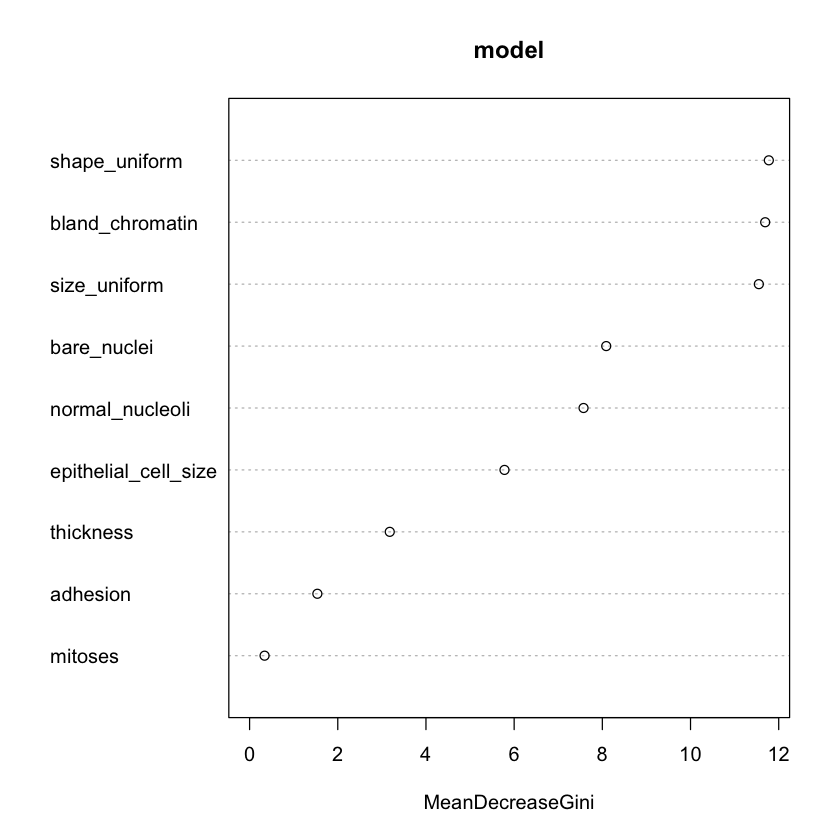

In [10]:
varImpPlot(model)

The most important features are shape uniformity, bland chromatin, and size uniformity.

In [11]:
pred <- predict(model, newdata = test)
table(pred, test$class)

           
pred        benign malignant
  benign       349         9
  malignant      7       182

In [12]:
# evaluate the accuracy, precision, recall, F1 on test data
cm <- as.matrix(table(Actual = test$class, Predicted = pred))
cm

accuracy <- sum(diag(cm)) / sum(cm)
precision <- diag(cm) / colSums(cm)
recall <- diag(cm) / rowSums(cm)
F1 <- 2 * precision * recall / (precision + recall) 

data.frame(accuracy, precision, recall, F1) 


           Predicted
Actual      benign malignant
  benign       349         7
  malignant      9       182

,accuracy,precision,recall,F1
benign,0.9707495,0.9748603,0.9803371,0.9775910
malignant,0.9707495,0.9629630,0.9528796,0.9578947


In [13]:
# evaluate the accuracy, precision, recall, F1 on training data
train.pred <- predict(model)
cm <- as.matrix(table(Actual = train$class, Predicted = train.pred))
cm

accuracy <- sum(diag(cm)) / sum(cm)
precision <- diag(cm) / colSums(cm)
recall <- diag(cm) / rowSums(cm)
F1 <- 2 * precision * recall / (precision + recall) 

data.frame(accuracy, precision, recall, F1) 


           Predicted
Actual      benign malignant
  benign        83         5
  malignant      4        44

,accuracy,precision,recall,F1
benign,0.9338235,0.9540230,0.9431818,0.9485714
malignant,0.9338235,0.8979592,0.9166667,0.9072165



Call:
roc.default(response = test$class, predictor = result.predicted.prob[,     "malignant"])

Data: result.predicted.prob[, "malignant"] in 356 controls (test$class benign) < 191 cases (test$class malignant).
Area under the curve: 0.9948

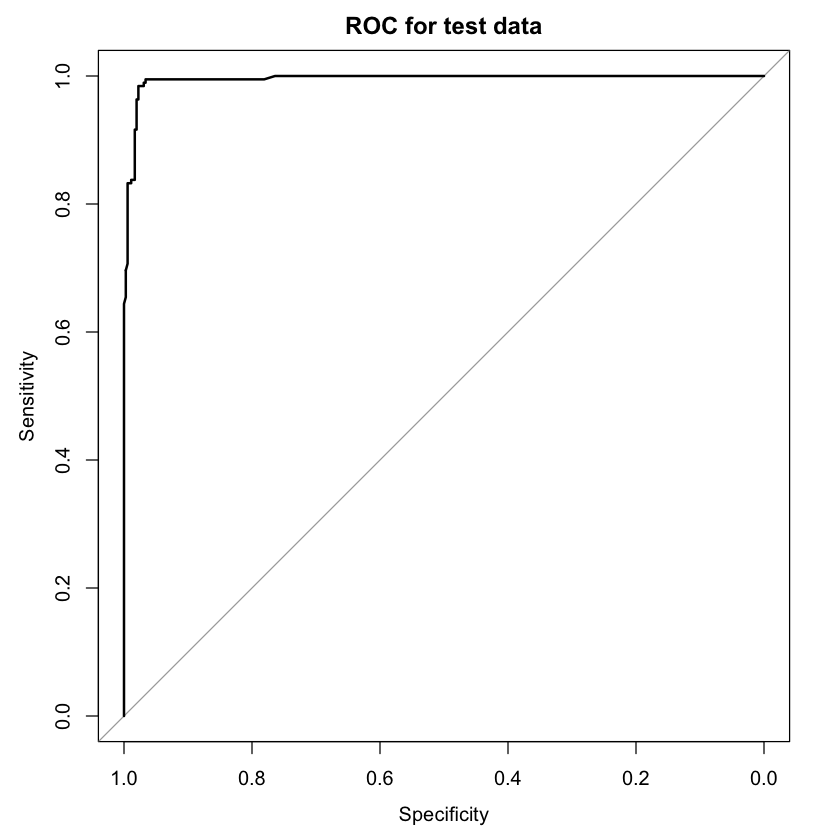

In [14]:
result.predicted.prob <- predict(model, newdata=test, type="prob")
result.roc <- roc(test$class, result.predicted.prob[, 'malignant'])
result.roc
plot(result.roc, main='ROC for test data')
#str(result.predicted.prob)
#result.predicted.prob[, 'malignant']


Call:
roc.default(response = train$class, predictor = train.predicted.prob[,     "malignant"])

Data: train.predicted.prob[, "malignant"] in 88 controls (train$class benign) < 48 cases (train$class malignant).
Area under the curve: 0.9714

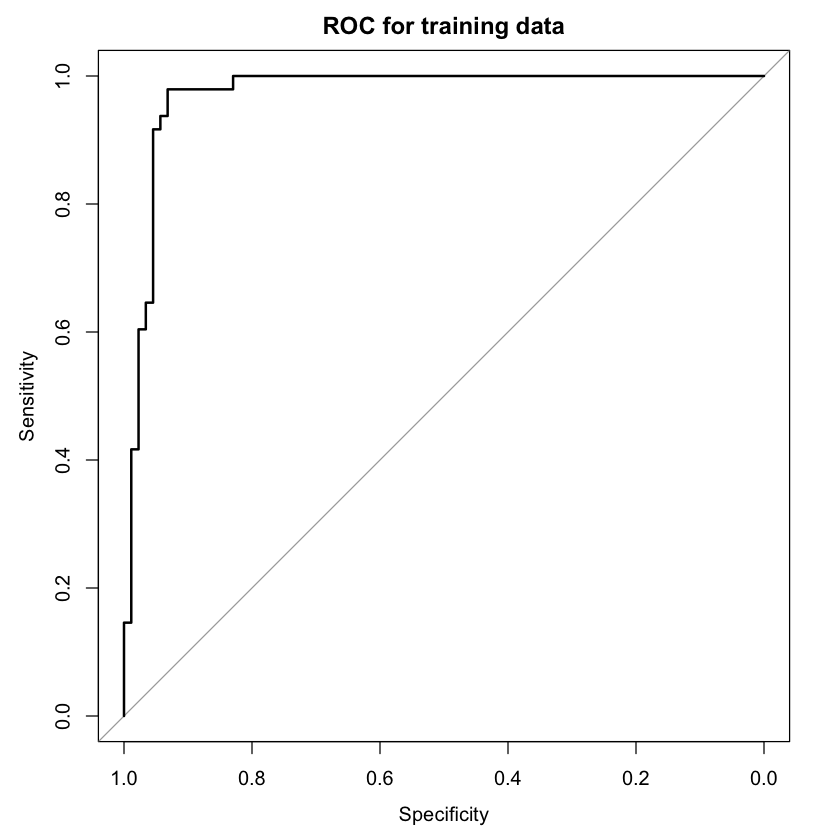

In [15]:
train.predicted.prob <- predict(model, type="prob")
train.roc <- roc(train$class, train.predicted.prob[, 'malignant'])
train.roc
plot(train.roc, main='ROC for training data')

# Conclusions

All features in the data set are associated with malignancy. My model found that the most important features to predict malignancy were the cell shape uniformity, the amount of bland chromatin, and the cell size uniformity. Interestingly, shape uniformity and size uniformity are highly correlated features. The model has accuracy of 0.971 on a test data set, with precision and recall of 0.963 and 0.953, respectively.

The model identifies the most important clinical features of breast cancer cells to predict malignancy, and can be used to classify cells as malignant or benign, which informs clinical treatment, as early detection of malignancy should improve patient outcomes.

Random forest has the advantage of being able to handle many features while avoiding overfitting. The feature levels in the data set are likely to be ordinal, and random forest handles ordinality in a data set easily without requiring normalization or one-hot encoding.